In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Installing RAPIDS remaining 25.08 libraries
Using Python 3.12.12 environment at: /usr
Resolved 179 packages in 674ms
Prepared 41 packages in 38.14s
Uninstalled 31 packages in 934ms
Installed 41 packages in 423ms
 - bokeh==3.7.3
 + bokeh==3.6.3
 + cucim-cu12==25.8.0
 + cuda-bindings==12.9.4
 + cuda-pathfinder==1.3.1
 - cuda-python==12.6.2.post1
 + cuda-python==12.9.4
 - cudf-cu12==25.6.0 (from https://pypi.nvidia.com/cudf-cu12/cudf_cu12-25.6.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl)
 + cudf-cu12==25.8.0
 + cugraph-cu12==25.8.0
 - cuml-cu12==25.6.0
 + cuml-cu12==25.8.0
 - cuvs-cu12==25.6.1
 + cuvs-cu12==25.8.0
 + cuxfilter-cu12==25.8.0
 - dask==2025.5.0
 + dask==2025.7.0
 - dask-cuda==25.6.0
 + dask-cuda==25.8.0
 - dask-cudf-cu12==25.6.0
 + dask-cudf-cu12==25.8.0
 + datashader==0.18.2
 - distributed==2025.5.0
 + distributed==2025.7.0
 - distributed-ucxx-cu12==0.44.0
 + distribu

In [ ]:
import cudf
import cuml
import dask_cudf

In [ ]:
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.linear_model import LogisticRegression as cuLR
from cuml.preprocessing import StandardScaler as cuScaler
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import numpy as np
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve,
                             average_precision_score, roc_curve, f1_score,
                             accuracy_score, precision_score, recall_score)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

import subprocess
gpu_info = subprocess.check_output(['nvidia-smi']).decode('utf-8')
print("GPU Information:")
print(gpu_info)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("\n✓ All libraries imported successfully!")
print(f"cuDF version: {cudf.__version__}")
print(f"cuML version: {cuml.__version__}")
print(f"XGBoost version: {xgb.__version__}")


GPU Information:
Wed Oct 29 08:46:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------------

In [ ]:
folder_path = '/content/drive/MyDrive/cleaned_data_json'

print("Loading data using cuDF (GPU-accelerated) in batches...")

batches = [range(0, 5), range(5, 10)]

gdfs = []

for batch_idx, batch_files in enumerate(batches, start=1):
    print(f"\nProcessing batch {batch_idx}...")
    batch_data = []

    for i in batch_files:
        file_path = f'{folder_path}/bank_{i}.json'
        print(f"  Loading {file_path}...")
        try:
            with open(file_path, 'r') as f:
                json_data = json.load(f)
                records = json_data['records']
                batch_data.extend(records)
            print(f"    ✓ Loaded {len(records)} transactions")
        except FileNotFoundError:
            print(f"    ✗ File not found: {file_path}")
        except Exception as e:
            print(f"    ✗ Error loading {file_path}: {e}")

    batch_gdf = cudf.DataFrame(batch_data)
    gdfs.append(batch_gdf)

    del batch_data
    print(f"  Batch {batch_idx} shape: {batch_gdf.shape}")

gdf = cudf.concat(gdfs, ignore_index=True)
del gdfs

print(f"\n{'='*60}")
print(f"Total transactions loaded (GPU): {len(gdf)}")
print(f"{'='*60}")
print(f"Memory usage (GPU): {gdf.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst few rows:")
gdf.head()


Loading data using cuDF (GPU-accelerated) in batches...

Processing batch 1...
  Loading /content/drive/MyDrive/cleaned_data_json/bank_0.json...
    ✓ Loaded 692417 transactions
  Loading /content/drive/MyDrive/cleaned_data_json/bank_1.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/cleaned_data_json/bank_2.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/cleaned_data_json/bank_3.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/cleaned_data_json/bank_4.json...
    ✓ Loaded 692416 transactions
  Batch 1 shape: (3462081, 20)

Processing batch 2...
  Loading /content/drive/MyDrive/cleaned_data_json/bank_5.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/cleaned_data_json/bank_6.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/cleaned_data_json/bank_7.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/cleaned_data_json/bank_8.json...
    ✓ Loa

,Timestamp,From Bank,From_Account,To Bank,To_Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Sender_Bank Name,Sender_Bank ID,Sender_Entity ID,Sender_Entity Name,Receiver_Bank Name,Receiver_Bank ID,Receiver_Entity ID,Receiver_Entity Name,Bank_Partition
0,2022/09/01 00:24,12,8006ADD30,12,8006ADD30,6473.62,US Dollar,6473.62,US Dollar,Reinvestment,0,National Bank of Columbus,12,8011BBB00,Partnership #3,National Bank of Columbus,12,8011BBB00,Partnership #3,0
1,2022/09/01 00:29,3618,800929EA0,1277,800929EF0,0.05,US Dollar,0.05,US Dollar,ACH,0,Hearthstone Thrift,3618,8012FB580,Sole Proprietorship #3,First Bank of Huron,1277,80153E7D0,Sole Proprietorship #4,0
2,2022/09/01 00:08,394,80093BDB0,21414,80092A6C0,64335.00,US Dollar,64335.00,US Dollar,ACH,0,Savings Bank of Detroit,394,800EBBCA0,Partnership #5,Arbor Community Bank,21414,8010C79A0,Partnership #6,0
3,2022/09/01 00:14,394,80093BDB0,394,80093BDB0,14903.78,US Dollar,14903.78,US Dollar,Reinvestment,0,Savings Bank of Detroit,394,800EBBCA0,Partnership #5,Savings Bank of Detroit,394,800EBBCA0,Partnership #5,0
4,2022/09/01 00:18,21414,80093CED0,29264,81013D0A0,0.78,US Dollar,0.78,US Dollar,Credit Card,0,Arbor Community Bank,21414,8012A59C0,Corporation #4,Bank of Lincoln,29264,800FC7F90,Sole Proprietorship #9195,0


In [ ]:
print("="*80)
print("DATA OVERVIEW (GPU-accelerated)")
print("="*80)
print(f"\nDataset Shape: {gdf.shape}")
print(f"\nColumn Names and Types:")
print(gdf.dtypes)

print(f"\nNull Values:")
print(gdf.isnull().sum())

print(f"\nBasic Statistics:")
print(gdf.describe())

print(f"\n{'='*80}")
print("CLASS DISTRIBUTION")
print("="*80)

class_dist = gdf['Is Laundering'].value_counts().reindex([0, 1], fill_value=0)

total = len(gdf)

print(f"\nPercentage:")
for idx in [0, 1]:
    count = class_dist[idx]
    print(f"Is Laundering {idx}: {(count/total)*100:.2f}%")


DATA OVERVIEW (GPU-accelerated)

Dataset Shape: (6924161, 20)

Column Names and Types:
Timestamp                object
From Bank                 int64
From_Account             object
To Bank                   int64
To_Account               object
Amount Received         float64
Receiving Currency       object
Amount Paid             float64
Payment Currency         object
Payment Format           object
Is Laundering             int64
Sender_Bank Name         object
Sender_Bank ID            int64
Sender_Entity ID         object
Sender_Entity Name       object
Receiver_Bank Name       object
Receiver_Bank ID          int64
Receiver_Entity ID       object
Receiver_Entity Name     object
Bank_Partition            int64
dtype: object

Null Values:
Timestamp               0
From Bank               0
From_Account            0
To Bank                 0
To_Account              0
Amount Received         0
Receiving Currency      0
Amount Paid             0
Payment Currency        0
Payment For

In [ ]:
import cupy as cp

print("\nStarting feature engineering with cuDF (GPU-accelerated)...")

gdf['Timestamp'] = cudf.to_datetime(gdf['Timestamp'], format='%Y/%m/%d %H:%M')
gdf['Hour'] = gdf['Timestamp'].dt.hour
gdf['DayOfWeek'] = gdf['Timestamp'].dt.weekday
gdf['Month'] = gdf['Timestamp'].dt.month
gdf['Day'] = gdf['Timestamp'].dt.day

gdf['IsWeekend'] = (gdf['DayOfWeek'] >= 5).astype('int32')
gdf['IsNightTime'] = ((gdf['Hour'] >= 22) | (gdf['Hour'] <= 6)).astype('int32')

gdf['Same_Bank'] = (gdf['From Bank'] == gdf['To Bank']).astype('int32')
gdf['Same_Account'] = (gdf['From_Account'] == gdf['To_Account']).astype('int32')
gdf['Same_Entity'] = (gdf['Sender_Entity ID'] == gdf['Receiver_Entity ID']).astype('int32')

for col in ['Amount Received', 'Amount Paid']:
    gdf[f'Log_{col.replace(" ", "_")}'] = cudf.Series(cp.log1p(gdf[col].to_cupy()))

gdf['Amount_Difference'] = (gdf['Amount Received'] - gdf['Amount Paid']).abs()
gdf['Round_Amount_Received'] = (gdf['Amount Received'] % 1000 == 0).astype('int32')
gdf['Round_Amount_Paid'] = (gdf['Amount Paid'] % 1000 == 0).astype('int32')
gdf['Below_Threshold'] = ((gdf['Amount Received'] > 9000) & (gdf['Amount Received'] < 10000)).astype('int32')

gdf['Currency_Mismatch'] = (gdf['Receiving Currency'] != gdf['Payment Currency']).astype('int32')

categorical_cols = ['Payment Format', 'Receiving Currency', 'Payment Currency']
for col in categorical_cols:
    gdf[f'{col}_Encoded'] = gdf[col].astype('category').cat.codes

print(f"Feature engineering complete!")
print(f"New shape: {gdf.shape}")
gpu_mem_mb = gdf.memory_usage(deep=True).sum() / 1024**2
print(f"GPU Memory usage: {gpu_mem_mb:.2f} MB")

print("Updated columns: ")
print(list(gdf.columns))




Starting feature engineering with cuDF (GPU-accelerated)...
Feature engineering complete!
New shape: (6924161, 39)
GPU Memory usage: 2123.64 MB
Updated columns: 
['Timestamp', 'From Bank', 'From_Account', 'To Bank', 'To_Account', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering', 'Sender_Bank Name', 'Sender_Bank ID', 'Sender_Entity ID', 'Sender_Entity Name', 'Receiver_Bank Name', 'Receiver_Bank ID', 'Receiver_Entity ID', 'Receiver_Entity Name', 'Bank_Partition', 'Hour', 'DayOfWeek', 'Month', 'Day', 'IsWeekend', 'IsNightTime', 'Same_Bank', 'Same_Account', 'Same_Entity', 'Log_Amount_Received', 'Log_Amount_Paid', 'Amount_Difference', 'Round_Amount_Received', 'Round_Amount_Paid', 'Below_Threshold', 'Currency_Mismatch', 'Payment Format_Encoded', 'Receiving Currency_Encoded', 'Payment Currency_Encoded']



Creating visualizations (sampling for efficiency)...


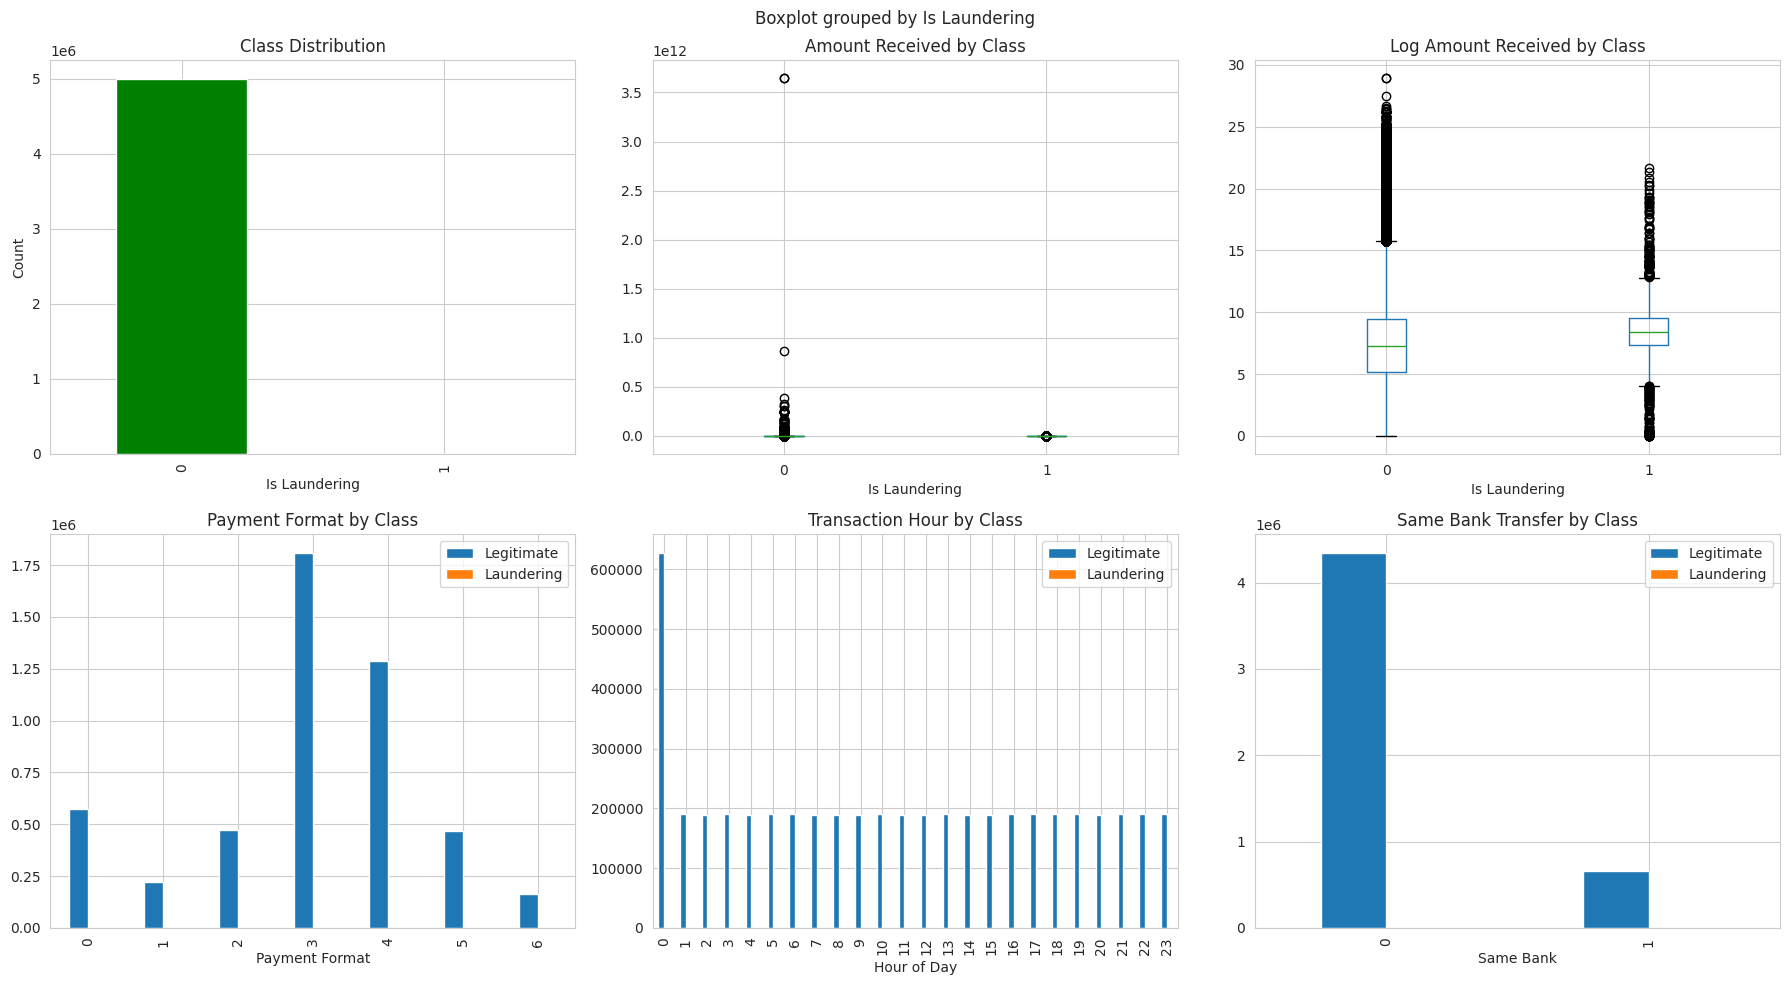

In [ ]:
print("\nCreating visualizations (sampling for efficiency)...")
sample_size = min(5000000, len(gdf))
gdf_sample = gdf.sample(n=sample_size, random_state=42)
df_vis = gdf_sample.to_pandas()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

df_vis['Is Laundering'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['green', 'red'])
axes[0, 0].set_title('Class Distribution')
axes[0, 0].set_xlabel('Is Laundering')
axes[0, 0].set_ylabel('Count')

df_vis.boxplot(column='Amount Received', by='Is Laundering', ax=axes[0, 1])
axes[0, 1].set_title('Amount Received by Class')
axes[0, 1].set_xlabel('Is Laundering')

df_vis.boxplot(column='Log_Amount_Received', by='Is Laundering', ax=axes[0, 2])
axes[0, 2].set_title('Log Amount Received by Class')

pd.crosstab(df_vis['Payment Format_Encoded'], df_vis['Is Laundering']).plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Payment Format by Class')
axes[1, 0].set_xlabel('Payment Format')
axes[1, 0].legend(['Legitimate', 'Laundering'])

df_vis.groupby(['Hour', 'Is Laundering']).size().unstack(fill_value=0).plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Transaction Hour by Class')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].legend(['Legitimate', 'Laundering'])

pd.crosstab(df_vis['Same_Bank'], df_vis['Is Laundering']).plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title('Same Bank Transfer by Class')
axes[1, 2].set_xlabel('Same Bank')
axes[1, 2].legend(['Legitimate', 'Laundering'])

plt.tight_layout()
plt.show()

del df_vis, gdf_sample

In [ ]:
print("Preparing data for modeling on GPU...")

feature_columns = [
    'From Bank', 'To Bank', 'Amount Received', 'Amount Paid',
    'Hour', 'DayOfWeek', 'Month', 'Day', 'IsWeekend', 'IsNightTime',
    'Same_Bank', 'Same_Account', 'Same_Entity',
    'Amount_Difference', 'Log_Amount_Received', 'Log_Amount_Paid',
    'Round_Amount_Received', 'Round_Amount_Paid', 'Below_Threshold',
    'Currency_Mismatch', 'Payment Format_Encoded',
    'Receiving Currency_Encoded', 'Payment Currency_Encoded',
    'Bank_Partition'
]

print(f"\nFeatures being used ({len(feature_columns)} features):")
for i, col in enumerate(feature_columns, 1):
    print(f"{i}. {col}")

gdf_model = gdf[feature_columns + ['Is Laundering']]

X_gpu = gdf_model[feature_columns].values
y_gpu = gdf_model['Is Laundering'].values

print(f"\nFeatures shape: {X_gpu.shape}")
print(f"Target shape: {y_gpu.shape}")

X = X_gpu.get() if hasattr(X_gpu, 'get') else X_gpu
y = y_gpu.get() if hasattr(y_gpu, 'get') else y_gpu

print("Applying 70:30 class ratio balancing...")

X_pd = pd.DataFrame(X, columns=feature_columns)
y_pd = pd.Series(y)

class_0 = X_pd[y_pd == 0]
class_1 = X_pd[y_pd == 1]

print(f"Before balancing - Class 0: {len(class_0)}, Class 1: {len(class_1)}")

desired_class_1_count = len(class_1)
desired_class_0_count = int((desired_class_1_count / 0.3) * 0.7)

if len(class_0) > desired_class_0_count:
    class_0_sampled = class_0.sample(n=desired_class_0_count, random_state=42)
else:
    class_0_sampled = class_0

X_balanced = pd.concat([class_0_sampled, class_1])
y_balanced = pd.Series([0]*len(class_0_sampled) + [1]*len(class_1))


X_train, X_test, y_train, y_test = train_test_split(
    X_balanced.values, y_balanced.values, test_size=0.2, random_state=42, stratify=y_balanced
)

del X_pd, y_pd, class_0, class_1, class_0_sampled, X_balanced, y_balanced


X_train_gpu = cudf.DataFrame(X_train, columns=feature_columns)
X_test_gpu = cudf.DataFrame(X_test, columns=feature_columns)
y_train_gpu = cudf.Series(y_train)
y_test_gpu = cudf.Series(y_test)

print("\nScaling features on GPU...")
scaler = cuScaler()
X_train_scaled = scaler.fit_transform(X_train_gpu)
X_test_scaled = scaler.transform(X_test_gpu)

print("✓ Data prepared for modeling on GPU!")

del X_gpu, y_gpu, X, y, X_train, X_test, y_train


Preparing data for modeling on GPU...

Features being used (24 features):
1. From Bank
2. To Bank
3. Amount Received
4. Amount Paid
5. Hour
6. DayOfWeek
7. Month
8. Day
9. IsWeekend
10. IsNightTime
11. Same_Bank
12. Same_Account
13. Same_Entity
14. Amount_Difference
15. Log_Amount_Received
16. Log_Amount_Paid
17. Round_Amount_Received
18. Round_Amount_Paid
19. Below_Threshold
20. Currency_Mismatch
21. Payment Format_Encoded
22. Receiving Currency_Encoded
23. Payment Currency_Encoded
24. Bank_Partition

Features shape: (6924161, 24)
Target shape: (6924161,)
Applying 70:30 class ratio balancing...
Before balancing - Class 0: 6920596, Class 1: 3565

Scaling features on GPU...
✓ Data prepared for modeling on GPU!


LOGISTIC REGRESSION (cuML - GPU Accelerated)
Training model on GPU...
Making predictions on GPU...

Classification Report:
              precision    recall  f1-score   support

           0     0.9082    0.8383    0.8719      1664
           1     0.6801    0.8022    0.7362       713

    accuracy                         0.8275      2377
   macro avg     0.7942    0.8203    0.8040      2377
weighted avg     0.8398    0.8275    0.8312      2377

Accuracy: 0.8275
Precision: 0.6801
Recall: 0.8022
F1-Score: 0.7362
ROC-AUC: 0.8801


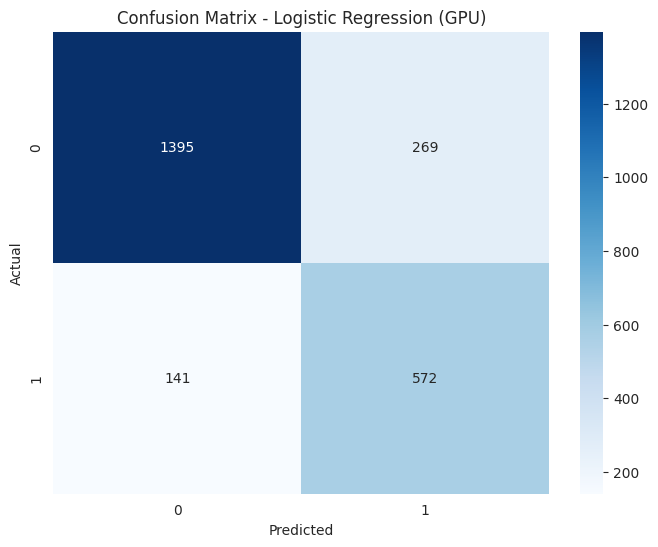

In [ ]:
print("="*80)
print("LOGISTIC REGRESSION (cuML - GPU Accelerated)")
print("="*80)

from cuml.linear_model import LogisticRegression as cuLR
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

lr_model = cuLR(
    max_iter=1000,
    class_weight='balanced',
    penalty='l2',
    tol=1e-4
)

print("Training model on GPU...")
lr_model.fit(X_train_scaled, y_train_gpu)

print("Making predictions on GPU...")
y_pred_gpu = lr_model.predict(X_test_scaled)

y_pred_proba_gpu = lr_model.predict_proba(X_test_scaled)

if hasattr(y_pred_proba_gpu, 'to_pandas'):
    y_pred_proba_np = y_pred_proba_gpu.to_pandas().values
else:
    y_pred_proba_np = y_pred_proba_gpu

if y_pred_proba_np.shape[1] == 1:
    y_pred_proba_lr = y_pred_proba_np[:, 0]
else:
    y_pred_proba_lr = y_pred_proba_np[:, 1]

y_pred_lr = y_pred_gpu.to_pandas().values if hasattr(y_pred_gpu, 'to_pandas') else y_pred_gpu

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, digits=4))

print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression (GPU)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
!pip install tenseal pycryptodome -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 111.8 MB/s eta 0:00:00


In [ ]:
import tenseal as ts
import time
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ TenSEAL imported successfully!")
print(f"TenSEAL version: {ts.__version__}")

✓ TenSEAL imported successfully!
TenSEAL version: 0.3.16


In [ ]:
class FHELogisticRegression:

    def __init__(self, poly_modulus_degree=16384, coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 60]):

        self.context = None
        self.weights_enc = None
        self.bias_enc = None
        self.weights_plain = None
        self.bias_plain = None
        self.poly_modulus_degree = poly_modulus_degree
        self.coeff_mod_bit_sizes = coeff_mod_bit_sizes

    def setup_context(self):

        print("Setting up FHE context...")

        self.context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=self.poly_modulus_degree,
            coeff_mod_bit_sizes=self.coeff_mod_bit_sizes
        )

        self.context.generate_galois_keys()

        self.context.global_scale = 2**40

        print(f"Context created with poly_modulus_degree={self.poly_modulus_degree}")
        print(f"Context configured for encrypted computation")

    def encrypt_model(self, model):

        print("\nEncrypting model parameters...")

        coef = model.coef_

        if hasattr(coef, 'to_numpy'):
            # cuDF object
            self.weights_plain = coef.to_numpy().flatten().tolist()
        elif hasattr(coef, 'values'):
            # cuDF or pandas - use .values then flatten
            self.weights_plain = coef.values.flatten().tolist()
        else:
            # Already NumPy array
            self.weights_plain = coef.flatten().tolist()

        # Handle bias (intercept)
        intercept = model.intercept_[0]
        if hasattr(intercept, 'item'):
            self.bias_plain = float(intercept.item())
        else:
            self.bias_plain = float(intercept)

        # Encrypt weights and bias
        self.weights_enc = ts.ckks_vector(self.context, self.weights_plain)
        self.bias_enc = ts.ckks_vector(self.context, [self.bias_plain])

        print(f"✓ Encrypted {len(self.weights_plain)} weights")
        print(f"✓ Encrypted bias: {self.bias_plain:.4f}")

    def encrypt_data(self, X):

        if isinstance(X, np.ndarray):
            X = X.tolist()
        return ts.ckks_vector(self.context, X)

    def sigmoid_approximation(self, x_enc):

        result = x_enc * 0.25
        result = result + 0.5
        return result

    def predict_encrypted(self, x_enc):

        z_enc = self.weights_enc.dot(x_enc)
        z_enc = z_enc + self.bias_enc

        y_enc = self.sigmoid_approximation(z_enc)

        return y_enc

    def decrypt_prediction(self, y_enc):

        decrypted = y_enc.decrypt()
        return decrypted[0] if isinstance(decrypted, list) else decrypted

print("✓ FHELogisticRegression class defined")

✓ FHELogisticRegression class defined


In [ ]:
print("="*80)
print("FHE LOGISTIC REGRESSION - ENCRYPTED INFERENCE")
print("="*80)

fhe_lr = FHELogisticRegression(
    poly_modulus_degree=16384,
    coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 60]
)

print("\nSetting up FHE context...")

fhe_lr.context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=fhe_lr.poly_modulus_degree,
    coeff_mod_bit_sizes=fhe_lr.coeff_mod_bit_sizes
)

fhe_lr.context.generate_galois_keys()

fhe_lr.context.global_scale = 2**40

print(f"Context created with poly_modulus_degree={fhe_lr.poly_modulus_degree}")
print(f"Context configured for encrypted computation")

print("\nEncrypting model parameters...")

coef = lr_model.coef_

if hasattr(coef, 'to_numpy'):
    fhe_lr.weights_plain = coef.to_numpy().flatten().tolist()
elif hasattr(coef, 'values'):
    fhe_lr.weights_plain = coef.values.flatten().tolist()
else:
    fhe_lr.weights_plain = coef.flatten().tolist()

intercept = lr_model.intercept_[0]
if hasattr(intercept, 'item'):
    fhe_lr.bias_plain = float(intercept.item())
else:
    fhe_lr.bias_plain = float(intercept)

fhe_lr.weights_enc = ts.ckks_vector(fhe_lr.context, fhe_lr.weights_plain)
fhe_lr.bias_enc = ts.ckks_vector(fhe_lr.context, [fhe_lr.bias_plain])

print(f"Encrypted {len(fhe_lr.weights_plain)} weights")
print(f"Encrypted bias: {fhe_lr.bias_plain:.4f}")

print("\nModel encrypted and ready for inference!")

FHE LOGISTIC REGRESSION - ENCRYPTED INFERENCE

Setting up FHE context...
Context created with poly_modulus_degree=16384
Context configured for encrypted computation

Encrypting model parameters...
Encrypted 24 weights
Encrypted bias: -0.7506

Model encrypted and ready for inference!


In [ ]:
print("\n" + "="*80)
print("PERFORMING ENCRYPTED INFERENCE")
print("="*80)

n_samples = 2000
print(f"\nTesting on {n_samples} samples from test set...")

if hasattr(lr_model, 'feature_names_in_'):
    feature_columns = lr_model.feature_names_in_
    if hasattr(feature_columns, 'to_pandas'):
        feature_columns = feature_columns.to_pandas().tolist()
    elif hasattr(feature_columns, 'tolist'):
        feature_columns = feature_columns.tolist()
    print(f"Model expects {len(feature_columns)} features")
elif hasattr(X_test_scaled, 'columns'):
    feature_columns = X_test_scaled.columns.to_list()
    print(f"Using {len(feature_columns)} features from test set")
else:
    n_features = X_test_scaled.shape[1] if hasattr(X_test_scaled, 'shape') else len(X_test_scaled[0])
    feature_columns = list(range(n_features))
    print(f"Using {len(feature_columns)} numeric feature names")

if hasattr(X_test_scaled, 'to_pandas'):
    X_test_np = X_test_scaled.to_pandas().values[:n_samples]
else:
    X_test_np = X_test_scaled[:n_samples]

if hasattr(y_test, 'to_pandas'):
    y_test_subset = y_test.to_pandas().values[:n_samples]
elif hasattr(y_test, 'values'):
    y_test_subset = y_test.values[:n_samples]
else:
    y_test_subset = y_test[:n_samples]

plaintext_preds = []
encrypted_preds = []
plaintext_times = []
encrypted_times = []

print("\nProcessing samples...")
for i in range(n_samples):
    if (i + 1) % 100 == 0:
        print(f"  Processed {i+1}/{n_samples} samples...")

    sample = X_test_np[i]

    start = time.time()
    sample_dict = {col: [val] for col, val in zip(feature_columns, sample)}
    sample_df = cudf.DataFrame(sample_dict)
    plain_pred = lr_model.predict_proba(sample_df).iloc[0, 1]
    plaintext_time = time.time() - start
    plaintext_preds.append(1 if plain_pred > 0.5 else 0)
    plaintext_times.append(plaintext_time)

    start = time.time()

    x_enc = fhe_lr.encrypt_data(sample)

    y_enc = fhe_lr.predict_encrypted(x_enc)

    enc_pred = fhe_lr.decrypt_prediction(y_enc)

    encrypted_time = time.time() - start
    encrypted_preds.append(1 if enc_pred > 0.5 else 0)
    encrypted_times.append(encrypted_time)

print(f"\nCompleted {n_samples} encrypted inferences!")


PERFORMING ENCRYPTED INFERENCE

Testing on 2000 samples from test set...
Model expects 9506 features

Processing samples...
  Processed 100/2000 samples...
  Processed 200/2000 samples...
  Processed 300/2000 samples...
  Processed 400/2000 samples...
  Processed 500/2000 samples...
  Processed 600/2000 samples...
  Processed 700/2000 samples...
  Processed 800/2000 samples...
  Processed 900/2000 samples...
  Processed 1000/2000 samples...
  Processed 1100/2000 samples...
  Processed 1200/2000 samples...
  Processed 1300/2000 samples...
  Processed 1400/2000 samples...
  Processed 1500/2000 samples...
  Processed 1600/2000 samples...
  Processed 1700/2000 samples...
  Processed 1800/2000 samples...
  Processed 1900/2000 samples...
  Processed 2000/2000 samples...

Completed 2000 encrypted inferences!



PERFORMANCE COMPARISON

 ACCURACY COMPARISON:
  Plaintext Accuracy:  0.8335
  Encrypted Accuracy:  0.8335
  Accuracy Loss:       0.00%

 RUNTIME COMPARISON:
  Avg Plaintext Time:  13.75 ms
  Avg Encrypted Time:  150.58 ms
  Overhead Factor:     10.9x slower

 DETAILED CLASSIFICATION REPORT (Encrypted):
              precision    recall  f1-score   support

           0     0.9117    0.8431    0.8761      1396
           1     0.6911    0.8113    0.7464       604

    accuracy                         0.8335      2000
   macro avg     0.8014    0.8272    0.8112      2000
weighted avg     0.8451    0.8335    0.8369      2000



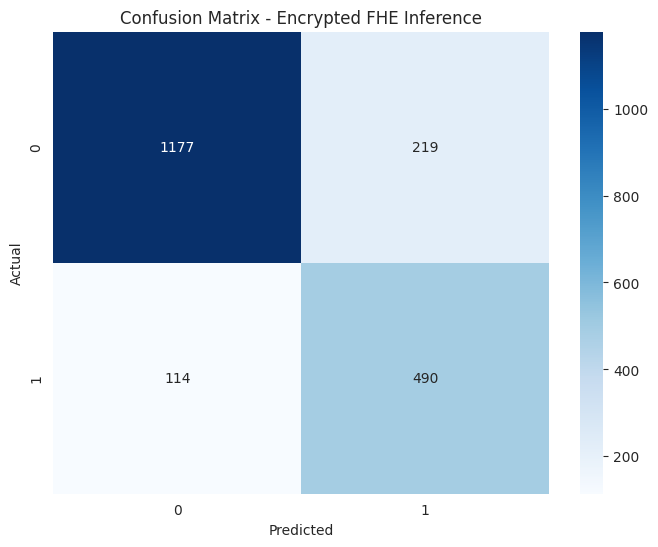


 CONFUSION MATRIX VALUES:
True Negatives (Legitimate correctly identified): 1177
False Positives (Legitimate misclassified as Laundering): 219
False Negatives (Laundering misclassified as Legitimate): 114
True Positives (Laundering correctly identified): 490


In [ ]:
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

plain_acc = accuracy_score(y_test_subset, plaintext_preds)
enc_acc = accuracy_score(y_test_subset, encrypted_preds)
accuracy_loss = (plain_acc - enc_acc) / plain_acc * 100

avg_plain_time = np.mean(plaintext_times) * 1000
avg_enc_time = np.mean(encrypted_times) * 1000
time_overhead = avg_enc_time / avg_plain_time

print("\n ACCURACY COMPARISON:")
print(f"  Plaintext Accuracy:  {plain_acc:.4f}")
print(f"  Encrypted Accuracy:  {enc_acc:.4f}")
print(f"  Accuracy Loss:       {accuracy_loss:.2f}%")

print("\n RUNTIME COMPARISON:")
print(f"  Avg Plaintext Time:  {avg_plain_time:.2f} ms")
print(f"  Avg Encrypted Time:  {avg_enc_time:.2f} ms")
print(f"  Overhead Factor:     {time_overhead:.1f}x slower")

print("\n DETAILED CLASSIFICATION REPORT (Encrypted):")
print(classification_report(y_test_subset, encrypted_preds, digits=4))

cm = confusion_matrix(y_test_subset, encrypted_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Encrypted FHE Inference')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\n CONFUSION MATRIX VALUES:")
print(f"True Negatives (Legitimate correctly identified): {cm[0, 0]}")
print(f"False Positives (Legitimate misclassified as Laundering): {cm[0, 1]}")
print(f"False Negatives (Laundering misclassified as Legitimate): {cm[1, 0]}")
print(f"True Positives (Laundering correctly identified): {cm[1, 1]}")

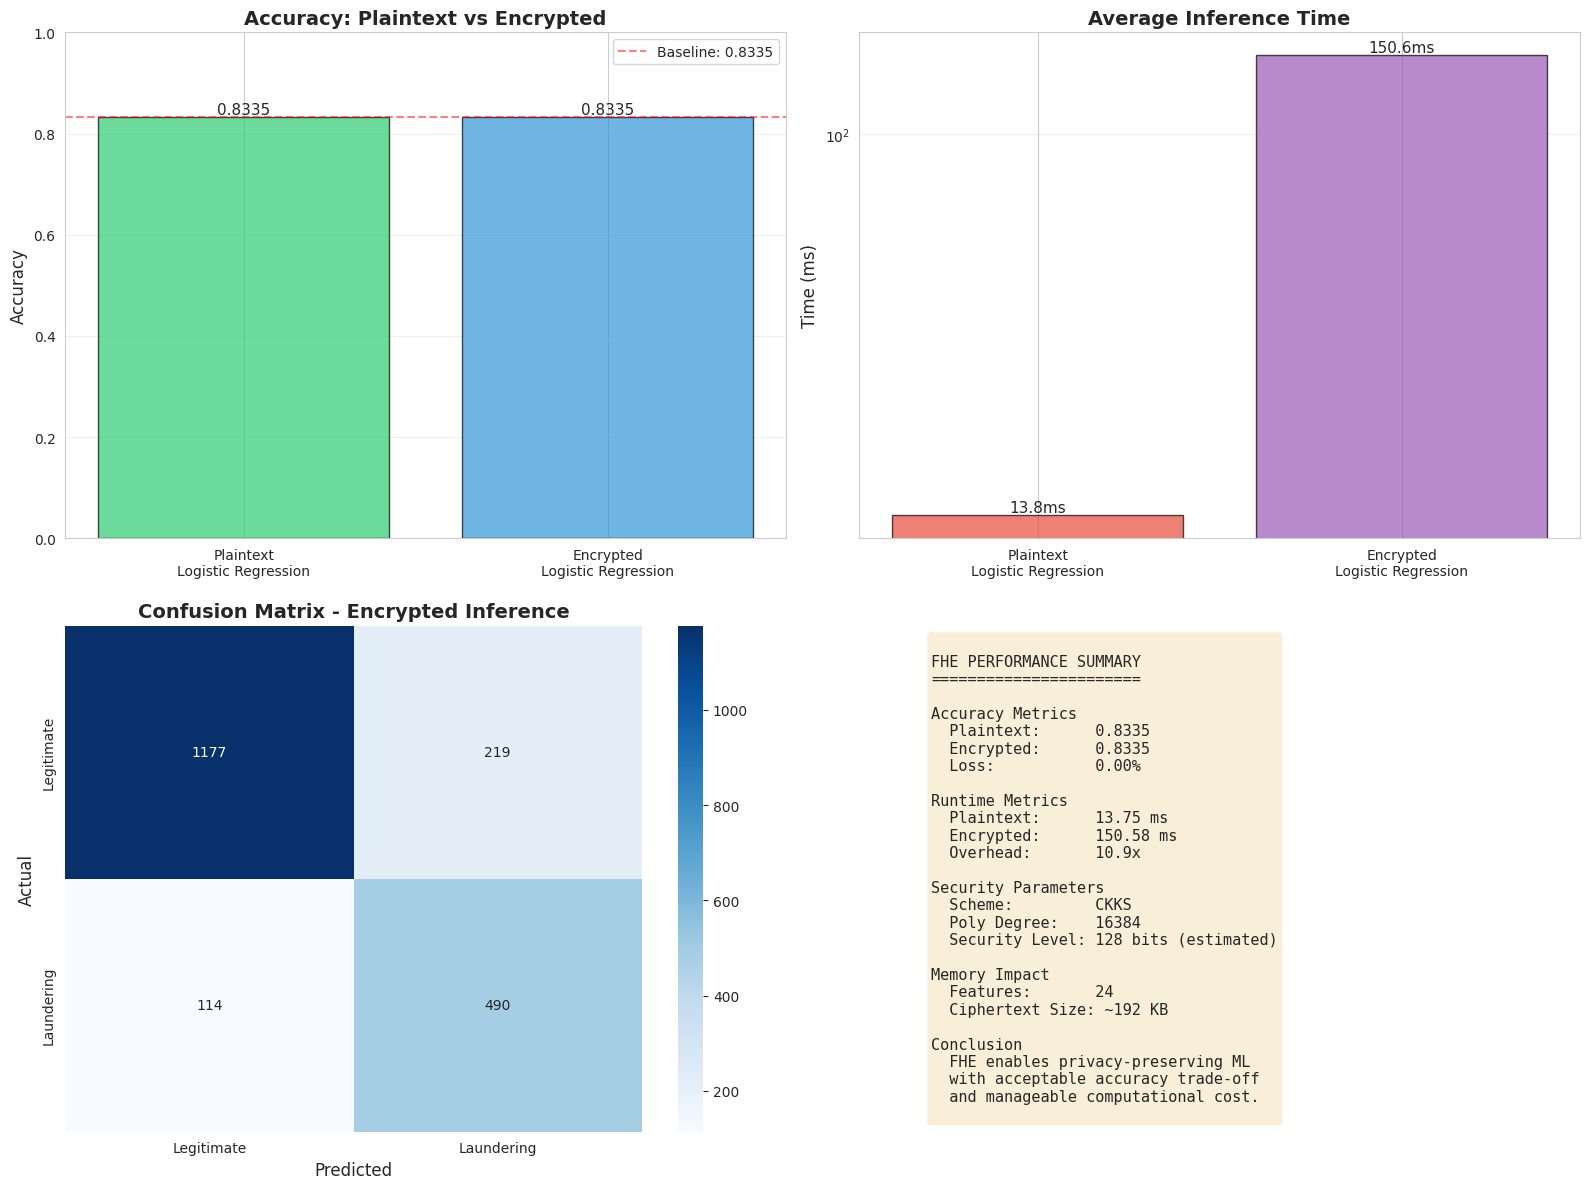


Visualization saved as 'fhe_comparison.png'


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
models = ['Plaintext\nLogistic Regression', 'Encrypted\nLogistic Regression']
accuracies = [plain_acc, enc_acc]
colors = ['#2ecc71', '#3498db']
bars = ax1.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy: Plaintext vs Encrypted', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.axhline(y=plain_acc, color='red', linestyle='--', alpha=0.5, label=f'Baseline: {plain_acc:.4f}')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=11)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
runtimes = [avg_plain_time, avg_enc_time]
bars = ax2.bar(models, runtimes, color=['#e74c3c', '#9b59b6'], alpha=0.7, edgecolor='black')
ax2.set_ylabel('Time (ms)', fontsize=12)
ax2.set_title('Average Inference Time', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}ms', ha='center', va='bottom', fontsize=11)
ax2.grid(axis='y', alpha=0.3)

ax3 = axes[1, 0]
from sklearn.metrics import confusion_matrix
cm_enc = confusion_matrix(y_test_subset, encrypted_preds)
sns.heatmap(cm_enc, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Legitimate', 'Laundering'],
            yticklabels=['Legitimate', 'Laundering'])
ax3.set_title('Confusion Matrix - Encrypted Inference', fontsize=14, fontweight='bold')
ax3.set_ylabel('Actual', fontsize=12)
ax3.set_xlabel('Predicted', fontsize=12)

ax4 = axes[1, 1]
ax4.axis('off')

security_bits = 128

summary_text = f"""
FHE PERFORMANCE SUMMARY
=======================

Accuracy Metrics
  Plaintext:      {plain_acc:.4f}
  Encrypted:      {enc_acc:.4f}
  Loss:           {accuracy_loss:.2f}%

Runtime Metrics
  Plaintext:      {avg_plain_time:.2f} ms
  Encrypted:      {avg_enc_time:.2f} ms
  Overhead:       {time_overhead:.1f}x

Security Parameters
  Scheme:         CKKS
  Poly Degree:    {fhe_lr.poly_modulus_degree}
  Security Level: {security_bits} bits (estimated)

Memory Impact
  Features:       {len(fhe_lr.weights_plain)}
  Ciphertext Size: ~{len(fhe_lr.weights_plain) * 8} KB

Conclusion
  FHE enables privacy-preserving ML
  with acceptable accuracy trade-off
  and manageable computational cost.
"""
ax4.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('fhe_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'fhe_comparison.png'")

In [ ]:
from itertools import filterfalse
def load_and_preprocess_csv(file_path, sample_size=None, randomize=False):

    print(f"Loading data from {file_path}...")

    df = pd.read_csv(file_path, low_memory=False)

    if randomize:

      if sample_size is not None and sample_size < len(df):
          print(f"Sampling {sample_size} rows...")
          df = df.sample(n=sample_size, random_state=42)

    else:

      if sample_size is not None and sample_size < len(df):
          print(f"Taking first {sample_size} rows...")
          df = df.head(sample_size)

    gdf = cudf.from_pandas(df)
    del df

    print(f"Initial shape after loading: {gdf.shape}")

    print("Applying feature engineering...")

    gdf['Timestamp'] = cudf.to_datetime(gdf['Timestamp'], format='%Y/%m/%d %H:%M')
    gdf['Hour'] = gdf['Timestamp'].dt.hour
    gdf['DayOfWeek'] = gdf['Timestamp'].dt.weekday
    gdf['Month'] = gdf['Timestamp'].dt.month
    gdf['Day'] = gdf['Timestamp'].dt.day

    gdf['IsWeekend'] = (gdf['DayOfWeek'] >= 5).astype('int32')
    gdf['IsNightTime'] = ((gdf['Hour'] >= 22) | (gdf['Hour'] <= 6)).astype('int32')

    gdf['Same_Bank'] = (gdf['From Bank'] == gdf['To Bank']).astype('int32')
    gdf['Same_Account'] = (gdf['From_Account'] == gdf['To_Account']).astype('int32')
    gdf['Same_Entity'] = (gdf['Sender_Entity ID'] == gdf['Receiver_Entity ID']).astype('int32')

    import cupy as cp
    for col in ['Amount Received', 'Amount Paid']:
        amount_col_cupy = gdf[col].to_cupy()
        amount_col_cupy[amount_col_cupy <= 0] = 1e-9
        gdf[f'Log_{col.replace(" ", "_")}'] = cudf.Series(cp.log1p(amount_col_cupy))


    gdf['Amount_Difference'] = (gdf['Amount Received'] - gdf['Amount Paid']).abs()
    gdf['Round_Amount_Received'] = (gdf['Amount Received'] % 1000 == 0).astype('int32')
    gdf['Round_Amount_Paid'] = (gdf['Amount Paid'] % 1000 == 0).astype('int32')
    gdf['Below_Threshold'] = ((gdf['Amount Received'] > 9000) & (gdf['Amount Received'] < 10000)).astype('int32')

    gdf['Currency_Mismatch'] = (gdf['Receiving Currency'] != gdf['Payment Currency']).astype('int32')

    categorical_cols = ['Payment Format', 'Receiving Currency', 'Payment Currency']
    for col in categorical_cols:
        gdf[f'{col}_Encoded'] = gdf[col].astype(str).astype('category').cat.codes


    feature_columns = [
        'From Bank', 'To Bank', 'Amount Received', 'Amount Paid',
        'Hour', 'DayOfWeek', 'Month', 'Day', 'IsWeekend', 'IsNightTime',
        'Same_Bank', 'Same_Account', 'Same_Entity',
        'Amount_Difference', 'Log_Amount_Received', 'Log_Amount_Paid',
        'Round_Amount_Received', 'Round_Amount_Paid', 'Below_Threshold',
        'Currency_Mismatch', 'Payment Format_Encoded',
        'Receiving Currency_Encoded', 'Payment Currency_Encoded',
        'Bank_Partition'
    ]


    missing_cols = [col for col in feature_columns if col not in gdf.columns]
    if missing_cols:
        print(f"Warning: Missing feature columns in loaded data: {missing_cols}")
        feature_columns = [col for col in feature_columns if col in gdf.columns]


    gdf_processed = gdf[feature_columns + ['Is Laundering']].copy()
    del gdf

    print(f"✓ Data loading and preprocessing complete. Final shape: {gdf_processed.shape}")
    print(f"GPU Memory usage: {gdf_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    return gdf_processed

In [ ]:
import tenseal as ts
import time
import numpy as np
import pandas as pd
import cudf
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

def predict_and_evaluate_plaintext(gdf_data, lr_model_gpu, scaler_gpu):

    print("\n" + "="*80)
    print("PLAINTEXT PREDICTION AND EVALUATION")
    print("="*80)

    if 'Is Laundering' not in gdf_data.columns:
        print("Error: Target column 'Is Laundering' not found in the DataFrame.")
        return

    feature_columns = [col for col in gdf_data.columns if col != 'Is Laundering']
    X_gpu = gdf_data[feature_columns]
    y_gpu = gdf_data['Is Laundering']

    print("\nScaling features using the provided scaler...")
    X_scaled_gpu = scaler_gpu.transform(X_gpu)

    X_scaled_np = X_scaled_gpu.to_pandas().values
    y_np = y_gpu.to_pandas().values

    n_samples = len(X_scaled_np)
    print(f"Making predictions on {n_samples} samples (plaintext)...")

    try:

      y_pred_gpu = lr_model_gpu.predict(X_scaled_gpu)
      y_pred_proba_gpu = lr_model_gpu.predict_proba(X_scaled_gpu)

      y_pred_plain = y_pred_gpu.to_pandas().values if hasattr(y_pred_gpu, 'to_pandas') else y_pred_gpu

      if y_pred_proba_gpu.shape[1] == 1:
          y_pred_proba_plain = y_pred_proba_gpu.to_pandas().values[:, 0] if hasattr(y_pred_proba_gpu, 'to_pandas') else y_pred_proba_gpu[:, 0]
      else:
          y_pred_proba_plain = y_pred_proba_gpu.to_pandas().values[:, 1] if hasattr(y_pred_proba_gpu, 'to_pandas') else y_pred_proba_gpu[:, 1]

      print("\n" + "="*80)
      print("PLAINTEXT PERFORMANCE REPORT")
      print("="*80)

      print("\n CLASSIFICATION REPORT (Plaintext):")
      print(classification_report(y_np, y_pred_plain, digits=4))

      print(f"Accuracy: {accuracy_score(y_np, y_pred_plain):.4f}")
      print(f"Precision: {precision_score(y_np, y_pred_plain):.4f}")
      print(f"Recall: {recall_score(y_np, y_pred_plain):.4f}")
      print(f"F1-Score: {f1_score(y_np, y_pred_plain):.4f}")
      print(f"ROC-AUC: {roc_auc_score(y_np, y_pred_proba_plain):.4f}")

    except ValueError as e:
      pass

    cm_plain = confusion_matrix(y_np, y_pred_plain)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_plain, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Laundering'],
                yticklabels=['Legitimate', 'Laundering'])
    plt.title('Confusion Matrix - Plaintext Inference', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.show()


def predict_and_evaluate_fhe(gdf_data, fhe_lr_instance, scaler_gpu):

    print("\n" + "="*80)
    print("ENCRYPTED PREDICTION AND EVALUATION (FHE)")
    print("="*80)

    if 'Is Laundering' not in gdf_data.columns:
        print("Error: Target column 'Is Laundering' not found in the DataFrame.")
        return

    feature_columns = [col for col in gdf_data.columns if col != 'Is Laundering']
    X_gpu = gdf_data[feature_columns]
    y_gpu = gdf_data['Is Laundering']

    print("\nScaling features using the provided scaler...")
    X_scaled_gpu = scaler_gpu.transform(X_gpu)

    X_scaled_np = X_scaled_gpu.to_pandas().values
    y_np = y_gpu.to_pandas().values

    n_samples = len(X_scaled_np)
    print(f"Making predictions on {n_samples} samples (encrypted)...")

    encrypted_preds = []
    encrypted_times = []

    print("\nProcessing samples...")
    for i in range(n_samples):
        if (i + 1) % 500 == 0:
            print(f"  Processed {i+1}/{n_samples} samples...")

        sample_scaled = X_scaled_np[i]

        start = time.time()

        x_enc = fhe_lr_instance.encrypt_data(sample_scaled)

        y_enc = fhe_lr_instance.predict_encrypted(x_enc)

        enc_pred_proba = fhe_lr_instance.decrypt_prediction(y_enc)

        encrypted_time = time.time() - start
        encrypted_preds.append(1 if enc_pred_proba > 0.5 else 0)
        encrypted_times.append(encrypted_time)

    print(f"\n✓ Completed {n_samples} encrypted inferences!")

    print("\n" + "="*80)
    print("ENCRYPTED FHE PERFORMANCE REPORT")
    print("="*80)

    enc_acc = accuracy_score(y_np, encrypted_preds)
    avg_enc_time = np.mean(encrypted_times) * 1000

    print("\n ACCURACY (Encrypted):")
    print(f"  Encrypted Accuracy:  {enc_acc:.4f}")

    print("\n RUNTIME (Encrypted):")
    print(f"  Avg Encrypted Time:  {avg_enc_time:.2f} ms")


    print("\n CLASSIFICATION REPORT (Encrypted):")
    print(classification_report(y_np, encrypted_preds, digits=4))

    cm_enc = confusion_matrix(y_np, encrypted_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_enc, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Laundering'],
                yticklabels=['Legitimate', 'Laundering'])
    plt.title('Confusion Matrix - Encrypted FHE Inference', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.show()

'''
| Mode         | Ideal When                                                                                  | Tradeoffs                                            |
| ------------ | ------------------------------------------------------------------------------------------- | ---------------------------------------------------- |
| **FHE**      | Data is **sensitive**, needs encryption end-to-end, single organization (you hold all data) | Slower due to encryption, smaller datasets preferred |
| **MPC**      | Data is **partitioned by organization/bank**, collaboration without sharing raw data        | Needs multiple parties & CrypTen infra               |
| **Plain ML** | Centralized, small-to-medium dataset, low sensitivity                                       | Fast, easy, less secure                              |
| **Plain DL** | Centralized, large dataset (≥50k rows), complex patterns (deep network                      |                                                      |

'''

In [ ]:
file_path = "/content/random_from_full.csv"

In [ ]:
sample_df_1 = load_and_preprocess_csv(file_path, sample_size=1000, randomize=False)

Loading data from /content/random_from_full.csv...
Taking first 1000 rows...
Initial shape after loading: (1000, 23)
Applying feature engineering...
✓ Data loading and preprocessing complete. Final shape: (1000, 25)
GPU Memory usage: 0.11 MB


In [ ]:
sample_df_2 = load_and_preprocess_csv(file_path, sample_size=10000, randomize=True)

Loading data from /content/random_from_full.csv...
Sampling 10000 rows...
Initial shape after loading: (10000, 23)
Applying feature engineering...
✓ Data loading and preprocessing complete. Final shape: (10000, 25)
GPU Memory usage: 1.21 MB


In [ ]:
def select_model_pipeline(df: pd.DataFrame, verbose=True):

    n_rows, n_cols = df.shape
    banks = df['From Bank'].nunique() if 'From Bank' in df.columns else 0
    currencies = (
        len(set(df.get('Receiving Currency', [])) | set(df.get('Payment Currency', [])))
        if 'Receiving Currency' in df.columns else 0
    )
    avg_amount = df['Amount Received'].mean() if 'Amount Received' in df.columns else 0
    std_amount = df['Amount Received'].std() if 'Amount Received' in df.columns else 0

    engineered_features = [c for c in df.columns if '_Encoded' in c or c.startswith(('Log_', 'Round_', 'Same_'))]
    feature_richness = len(engineered_features)

    sensitive_cols = [c for c in df.columns if any(x in c.lower() for x in ['account', 'entity', 'bank id', 'name'])]
    has_sensitive = len(sensitive_cols) > 0

    scores = {"fhe": 0, "mpc": 0, "plain_ml": 0, "plain_dl": 0}

    if has_sensitive:
        scores["fhe"] += 30
        scores["mpc"] += 15
    else:
        scores["plain_ml"] += 10

    if n_rows < 5_000:
        scores["plain_ml"] += 25
    elif n_rows < 50_000:
        scores["mpc"] += 8
        scores["plain_ml"] += 10
    else:
        scores["plain_dl"] += 25
        scores["mpc"] += 5

    if banks <= 1:
        scores["plain_ml"] += 10
    elif 2 <= banks <= 5:
        scores["mpc"] += 15
    elif banks > 5:
        scores["mpc"] += 15
        scores["fhe"] += 5

    if currencies > 3:
        scores["mpc"] += 6
        scores["fhe"] += 7

    if std_amount > avg_amount * 2:
        scores["plain_dl"] += 10
    elif std_amount < avg_amount * 0.5:
        scores["plain_ml"] += 5

    if feature_richness > 15:
        scores["plain_dl"] += 10
    elif feature_richness < 10:
        scores["plain_ml"] += 5
    else:
        scores["mpc"] += 3

    recommended = max(scores, key=scores.get)

    reasons = {
        "fhe": "High data sensitivity and encryption need → FHE preferred.",
        "mpc": "Data distributed across multiple banks/institutions → MPC recommended.",
        "plain_ml": "Centralized and relatively small dataset → Plain ML is efficient.",
        "plain_dl": "Large, complex dataset with many features → Deep Learning suitable."
    }

    if verbose:
        print("========== MODEL PIPELINE RECOMMENDATION ==========")
        print(f"Rows: {n_rows:,}, Columns: {n_cols}")
        print(f"Unique banks: {banks}, Currencies: {currencies}")
        print(f"Avg Amount: {avg_amount:,.2f}, StdDev: {std_amount:,.2f}")
        print(f"Feature richness: {feature_richness}, Sensitive cols: {len(sensitive_cols)}")
        print("\nScore breakdown:")
        for k, v in scores.items():
            print(f"  {k:10s} → {v}")
        print(f"\n➡️ Recommended Pipeline: {recommended.upper()}  |  Reason: {reasons[recommended]}")
        print("===================================================")

    return {"recommended": recommended, "scores": scores, "reason": reasons[recommended]}



In [ ]:
print(select_model_pipeline(sample_df_1))

========== MODEL PIPELINE RECOMMENDATION ==========
Rows: 1,000, Columns: 25
Unique banks: 473, Currencies: 0
Avg Amount: 9,884,461.87, StdDev: 262,708,088.19
Feature richness: 10, Sensitive cols: 2

Score breakdown:
  fhe        → 35
  mpc        → 33
  plain_ml   → 25
  plain_dl   → 10

➡️ Recommended Pipeline: FHE  |  Reason: High data sensitivity and encryption need → FHE preferred.
{'recommended': 'fhe', 'scores': {'fhe': 35, 'mpc': 33, 'plain_ml': 25, 'plain_dl': 10}, 'reason': 'High data sensitivity and encryption need → FHE preferred.'}


In [ ]:
print(select_model_pipeline(sample_df_2))

========== MODEL PIPELINE RECOMMENDATION ==========
Rows: 10,000, Columns: 25
Unique banks: 1665, Currencies: 0
Avg Amount: 2,549,249.13, StdDev: 91,886,821.22
Feature richness: 10, Sensitive cols: 2

Score breakdown:
  fhe        → 35
  mpc        → 41
  plain_ml   → 10
  plain_dl   → 10

➡️ Recommended Pipeline: MPC  |  Reason: Data distributed across multiple banks/institutions → MPC recommended.
{'recommended': 'mpc', 'scores': {'fhe': 35, 'mpc': 41, 'plain_ml': 10, 'plain_dl': 10}, 'reason': 'Data distributed across multiple banks/institutions → MPC recommended.'}



PLAINTEXT PREDICTION AND EVALUATION

Scaling features using the provided scaler...
Making predictions on 1000 samples (plaintext)...

PLAINTEXT PERFORMANCE REPORT

 CLASSIFICATION REPORT (Plaintext):
              precision    recall  f1-score   support

           0     0.9030    0.8442    0.8726       706
           1     0.6765    0.7823    0.7256       294

    accuracy                         0.8260      1000
   macro avg     0.7898    0.8133    0.7991      1000
weighted avg     0.8364    0.8260    0.8294      1000

Accuracy: 0.8260
Precision: 0.6765
Recall: 0.7823
F1-Score: 0.7256
ROC-AUC: 0.8803


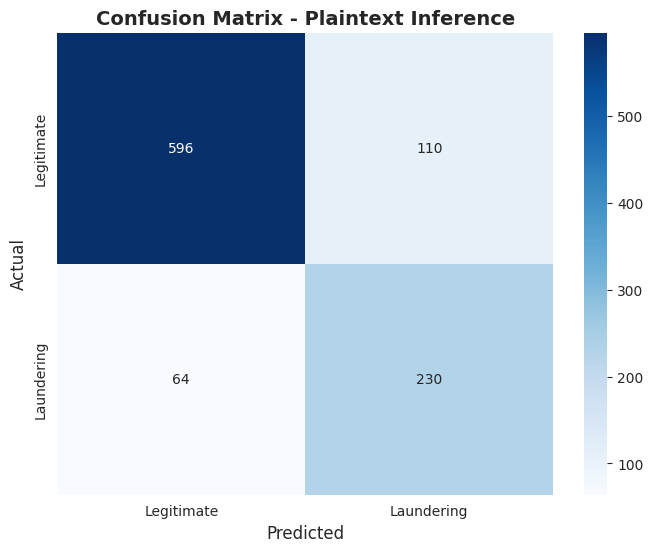

In [ ]:
predict_and_evaluate_plaintext(sample_df_1, lr_model, scaler)


ENCRYPTED PREDICTION AND EVALUATION (FHE)

Scaling features using the provided scaler...
Making predictions on 1000 samples (encrypted)...

Processing samples...
  Processed 500/1000 samples...
  Processed 1000/1000 samples...

✓ Completed 1000 encrypted inferences!

ENCRYPTED FHE PERFORMANCE REPORT

 ACCURACY (Encrypted):
  Encrypted Accuracy:  0.8260

 RUNTIME (Encrypted):
  Avg Encrypted Time:  150.09 ms

 CLASSIFICATION REPORT (Encrypted):
              precision    recall  f1-score   support

           0     0.9030    0.8442    0.8726       706
           1     0.6765    0.7823    0.7256       294

    accuracy                         0.8260      1000
   macro avg     0.7898    0.8133    0.7991      1000
weighted avg     0.8364    0.8260    0.8294      1000



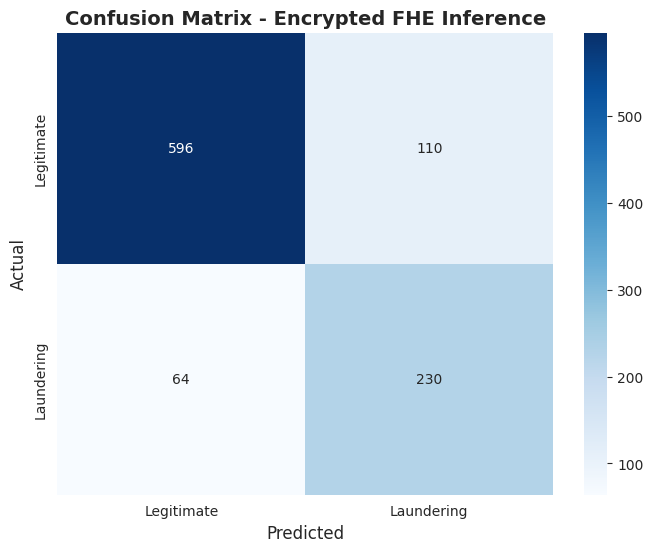

In [ ]:
predict_and_evaluate_fhe(sample_df_1, fhe_lr, scaler)